# Finding Exoplanets with Python

## What is the transit method??
![](pictures/phase_curve.png)
The transit method is one of the many techniques for detecting exoplanets. This method makes use of the observation of periodic dips of light in a star, which are caused by a planet passing in front of it, which blocks a portion on the light emmitted. 

### How does the transit method work?
1. **Observing Dips in light**: As the planet orbits its parent star, it causes a temporary decrease in the star's brightness. The depth of the dip will correspond to the size of the planet.
2. **Determining Orbital Period**: The Time interval between successive transits allows astronomers to calculate the planet's orbital period, which can help determine the distance between the planet and the star(based on Kepler's Laws of planetary motion)
3. **Planet Characterisation**: The transit method can also provide valuable information about the planet's physical characteristics. By analysing the light that passes through the planet's atmosphere during a transit, scientists can infer it's chemical composition. 
4. **Follow up observations**: To confirm a planet as a candidate, astronomers require multiple transits. 

In [1]:
# Import dependencies
import matplotlib.pyplot as plt 
from lightkurve import search_targetpixelfile
from lightkurve import TessTargetPixelFile
import lightkurve as lk
import numpy as np
import reference_finder
%matplotlib inline

## What is a Target Pixel File?
Target Pixel Files(or TPFs) are data structures that contain the original imaging data obtained from the space telescopes like kepler, k2 and TESS. Now we will download the files of the subject that we wish to study. 

In [2]:
pixelFile = search_targetpixelfile("KIC 6922244", author="Kepler", cadence="long", quarter=4).download()

* 6922244 is the star we will be looking at(KIC6922244), also known as Kepler-8
* Quarter stands for a time frame. each year has 4 quarters, this means that we are looking at data from the 1st year of the kepler mission. 

<Axes: title={'center': 'Target ID: 6922244, Cadence: 11958'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

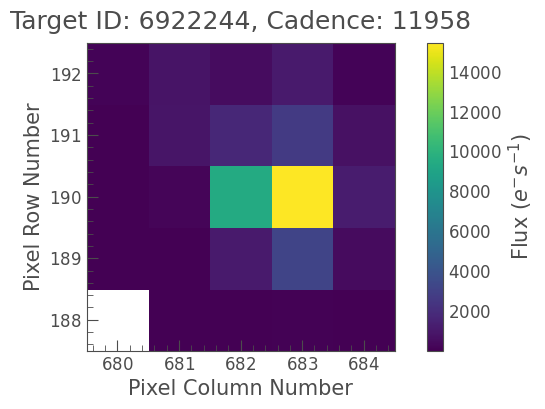

In [3]:
pixelFile.plot(frame=42)

Looking at these graphs is pretty fun, but overall useless on their own, so we'll need to convert these frames into a graph(<b>AKA</b> a light curve)

Aperture masks make the image better to analyse. 

Text(0.5, 1.0, 'Flux over time')

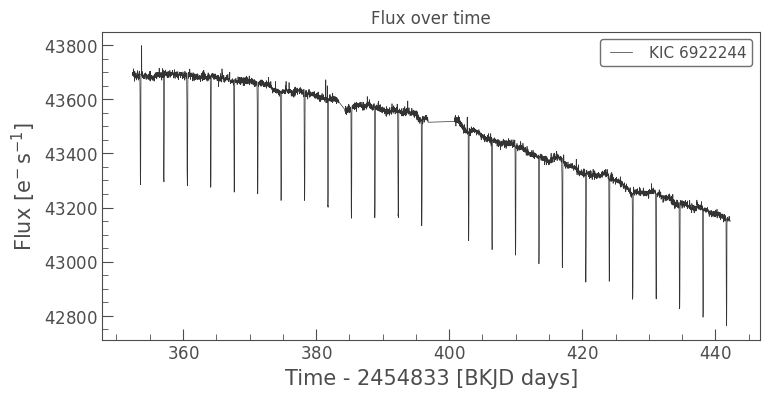

In [4]:
lc = pixelFile.to_lightcurve(aperture_mask=pixelFile.pipeline_mask)
lc.plot()
plt.title('Flux over time')

From this light curve, we can see periodic dips in the luminosity of Kepler-8. From this we can ascertain that <b>something</b> is orbiting the star. For some reason, the overall luminosity of the star seems to be decreasing. This can be due to multiple factors: 
* Maybe the telescope was moving away from the star during observation(this data is recorded from the [Kepler space telescope](https://en.wikipedia.org/wiki/Kepler_space_telescope))
* Maybe a dust cloud? 
* Astrophage? :P

However, the overall luminosity dropping makes it harder for us to analyse the star, therefore we need to make use of the below command. 

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

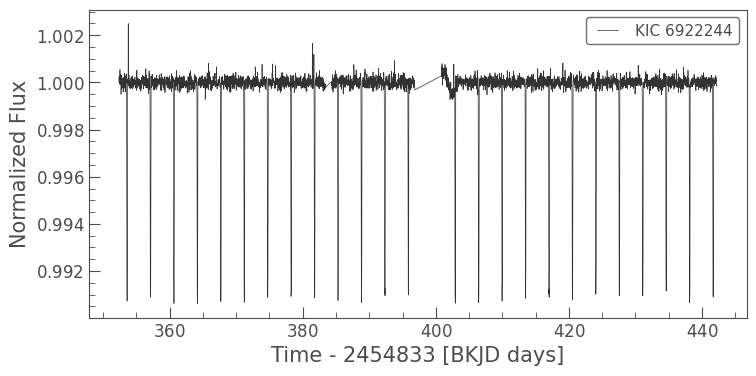

In [5]:
flat_lc = lc.flatten()
flat_lc.plot()

We now phase fold the light curve to verify that the period and the transit time correspond to the transit signal. Essentially the result is the frequency spikes are folded on each other if the period is correct. 

But how do we ascertain the correct period? We make use of a statistical analysis called a [periodogram](https://en.wikipedia.org/wiki/Periodogram)(a periodogram is an estimate of the spectral density of the signal). This essentially shows all the repititive patterns in your graph, and gives you a most likely candidate. 

<Axes: xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

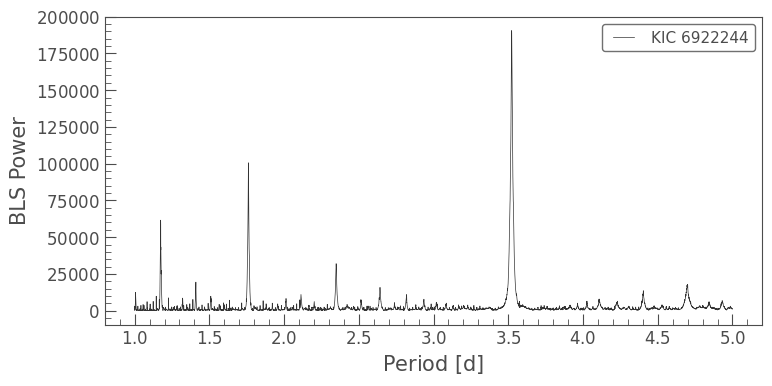

In [6]:
period = np.linspace(1,5,10000)
# BLS = Box Least Squares
bls = lc.to_periodogram(method="bls", period=period, frequency_factor=500)
bls.plot()

We'll now take the period with the highest peak, and that is what we will use for phase folding the light curve. 

In [7]:
highest_peak = bls.period_at_max_power
print(f"Period of highest peak in periodogram: {highest_peak}")
highest_peak_transit_time = bls.transit_time_at_max_power
print(f"Transit time of highest peak in periodogram: {highest_peak_transit_time}")
highest_peak_duration = bls.duration_at_max_power
print(f"Duration of highest peak in periodogram: {highest_peak_duration}")

Period of highest peak in periodogram: 3.522652265226523 d
Transit time of highest peak in periodogram: 353.60132485035285
Duration of highest peak in periodogram: 0.1 d


We'll use the highest peak period to make a folded light curve. 

<Axes: xlabel='Phase [JD]', ylabel='Normalized Flux'>

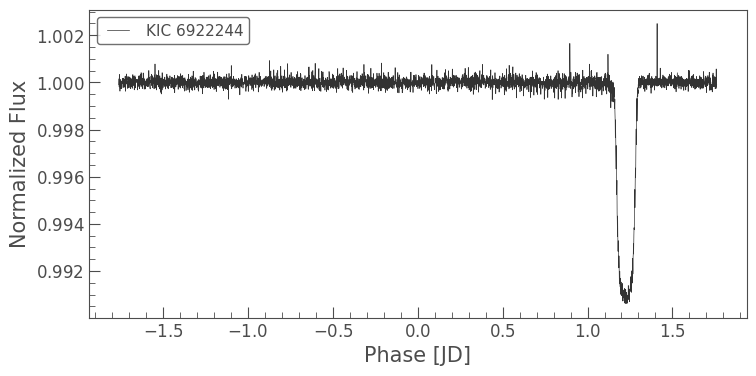

In [8]:
folded_lc = flat_lc.fold(period=highest_peak)
folded_lc.plot()

We can make an alternate light curve that is a scatter plot. 

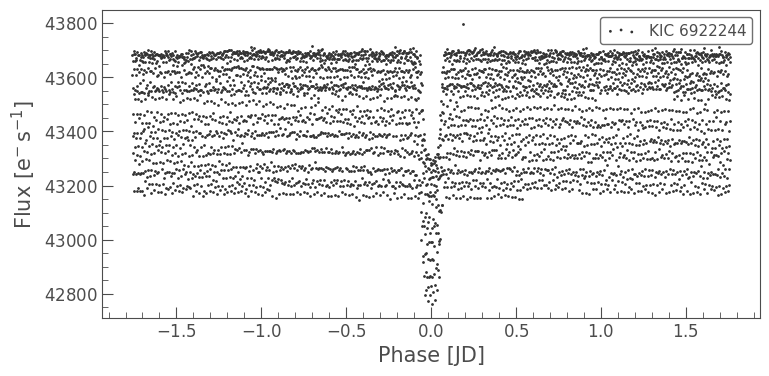

In [9]:
scatter_lc = lc.fold(period=highest_peak, epoch_time=highest_peak_transit_time).scatter()

## Analysing Various stars

#### TESS Data: 
> [https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html)

Use this link to access TESS data(this is updated more regularly. (TESS CTL mission, advanced search)

- Distance: 12-24 parsec
- T_eff(Temperature): 2200-35004

Use this [link](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html?searchQuery=%7B%22service%22%3A%22CTLFILTERED%22%2C%22inputText%22%3A%5B%7B%22paramName%22%3A%22Teff%22%2C%22niceName%22%3A%22Teff%22%2C%22values%22%3A%5B%7B%22min%22%3A2200%2C%22max%22%3A3500%7D%5D%2C%22valString%22%3A%22%5B2200%2C%203500%5D%22%2C%22isDate%22%3Afalse%2C%22facetType%22%3A%22numeric%22%2C%22min%22%3A2200%2C%22max%22%3A3500%2C%22displayString%22%3A%22%5B2200%2C%203500%5D%22%7D%2C%7B%22paramName%22%3A%22d%22%2C%22niceName%22%3A%22d%22%2C%22values%22%3A%5B%7B%22min%22%3A12%2C%22max%22%3A24%7D%5D%2C%22valString%22%3A%22%5B12%2C%2024%5D%22%2C%22isDate%22%3Afalse%2C%22facetType%22%3A%22numeric%22%2C%22min%22%3A12%2C%22max%22%3A24%2C%22displayString%22%3A%22%5B12%2C%2024%5D%22%7D%5D%2C%22position%22%3A%22undefined%2C%20undefined%2C%20undefined%22%2C%22paramsService%22%3A%22Mast.Catalogs.Filtered.Ctl.Rows%22%2C%22title%22%3A%22CTL%20v8.01%3A%20%20Advanced%20Search%201%22%2C%22tooltip%22%3A%22%5B2200%2C%203500%5D%3B%20%5B12%2C%2024%5D%3B%20%22%2C%22columns%22%3A%22*%22%7D) to directly perform the search with the above parameters.

In [30]:
def analyse_star(star, mission, compact=False):
    '''
    A helper function to plot all the graphs for a particular star. 
    Parameters:
    star(str): The star that is being studied.
    author(str): The origin of that data(Kepler, TESS etc)
    compact(bool): Specify True if you want the graphs to be in a compact format
    '''
    search_result = search_targetpixelfile(star, mission=mission)
    print(search_result)
    choice = int(input('Which result do you want to download? '))
    pixelFile = search_result[choice].download()
    # Get the Lightcurve
    lc = pixelFile.to_lightcurve(aperture_mask=pixelFile.pipeline_mask)
    # Flatten Lightcurve
    flat_lc = lc.flatten()
    # Obtain Periodogram
    period = np.linspace(1,5,10000)
    bls = lc.to_periodogram(method="bls", period=period, frequency_factor=500) # BLS = Box Least Squares
    highest_peak = bls.period_at_max_power
    print(f"Period of highest peak in periodogram: {highest_peak}")
    highest_peak_transit_time = bls.transit_time_at_max_power
    print(f"Transit time of highest peak in periodogram: {highest_peak_transit_time}")
    highest_peak_duration = bls.duration_at_max_power
    print(f"Duration of highest peak in periodogram: {highest_peak_duration}")
    folded_lc = flat_lc.fold(period=highest_peak)

    if compact:
        fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,10))
        lc.plot(ax=ax[0,0], color='black') # Flux over time
        ax[0,0].set_title('Luminosity over Time')
        flat_lc.plot(ax=ax[0,1], color='black') # Flattened Lightcurve
        ax[0,1].set_title('Flux over Time(Flattened)')
        bls.plot(ax=ax[1,0], color='black') # Periodogram
        ax[1,0].set_title('Periodogram')
        folded_lc.plot(ax=ax[1,1], color='black') # Folded lightcurve
        ax[1,1].set_title('Folded Lightcurve') 
        lc.fold(period=highest_peak, epoch_time=highest_peak_transit_time).scatter(ax=ax[2,0], color='black')
        ax[2,0].set_title('Scatter Lightcurve plot') # Scattered Lightcurve plot
        fig.delaxes(ax[2,1]) # The indexing is zero-based here
        fig.suptitle(f'Overview of {star}')
        plt.tight_layout()
    else: 
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, ncols=1, figsize=(8,16))
        lc.plot(ax=ax1, color='black') # Flux over time
        ax1.set_title('Luminosity over Time')
        flat_lc.plot(ax=ax2, color='black') # Flattened Lightcurve
        ax2.set_title('Flux over Time(Flattened)')
        bls.plot(ax=ax3, color='black') # Periodogram
        ax3.set_title('Periodogram')
        folded_lc.plot(ax=ax4, color='black') # Folded lightcurve
        ax4.set_title('Folded Lightcurve') 
        lc.fold(period=highest_peak, epoch_time=highest_peak_transit_time).scatter(ax=ax5, color='black')
        ax5.set_title('Scatter Lightcurve plot') # Scattered Lightcurve plot
        plt.tight_layout()

Period of highest peak in periodogram: 1.1648164816481648 d
Transit time of highest peak in periodogram: 353.5271674113668
Duration of highest peak in periodogram: 0.05 d
Query completed in 2.1413557529449463 seconds.


bibcode,journal,title,year,volume,Pages,doi
object,object,object,int16,int32,object,object
2024AJ....167..101C,AJ,Searching the SN 1987A SETI Ellipsoid with TESS.,2024,167,,10.3847/1538-3881/ad2064
2024MNRAS.527.5244Y,MNRAS,The eccentric Koza-Lidov mechanism as the cause of exocomet transits of KIC 8462852.,2024,527,5244-5264,10.1093/mnras/stad2963
2024AJ....167...24K,AJ,Deconstructing Alien Hunting.,2024,167,,10.3847/1538-3881/ad0cbe
2024AJ....167...85H,AJ,An Episode of Occultation Events in Gaia21bcv.,2024,167,,10.3847/1538-3881/ad1931
2023AJ....166...84A,AJ,A VERITAS/Breakthrough Listen Search for Optical Technosignatures.,2023,166,,10.3847/1538-3881/ace347
2023A&A...676A..88P,A&A,PM 1-322: New variable planetary nebula.,2023,676,,10.1051/0004-6361/202346162
2023MNRAS.524.4506S,MNRAS,On the new mechanism of planetary long-period debris formation around white dwarfs.,2023,524,4506-4520,10.1093/mnras/stad2006
2023MNRAS.524.4196H,MNRAS,Unresolved Rossby and gravity modes in 214 A and F stars showing rotational modulation.,2023,524,4196-4211,10.1093/mnras/stad1971
2023AJ....165..114Z,AJ,The Breakthrough Listen Search for Intelligent Life: A Laser Search Pipeline for the Automated Planet Finder.,2023,165,,10.3847/1538-3881/acb342


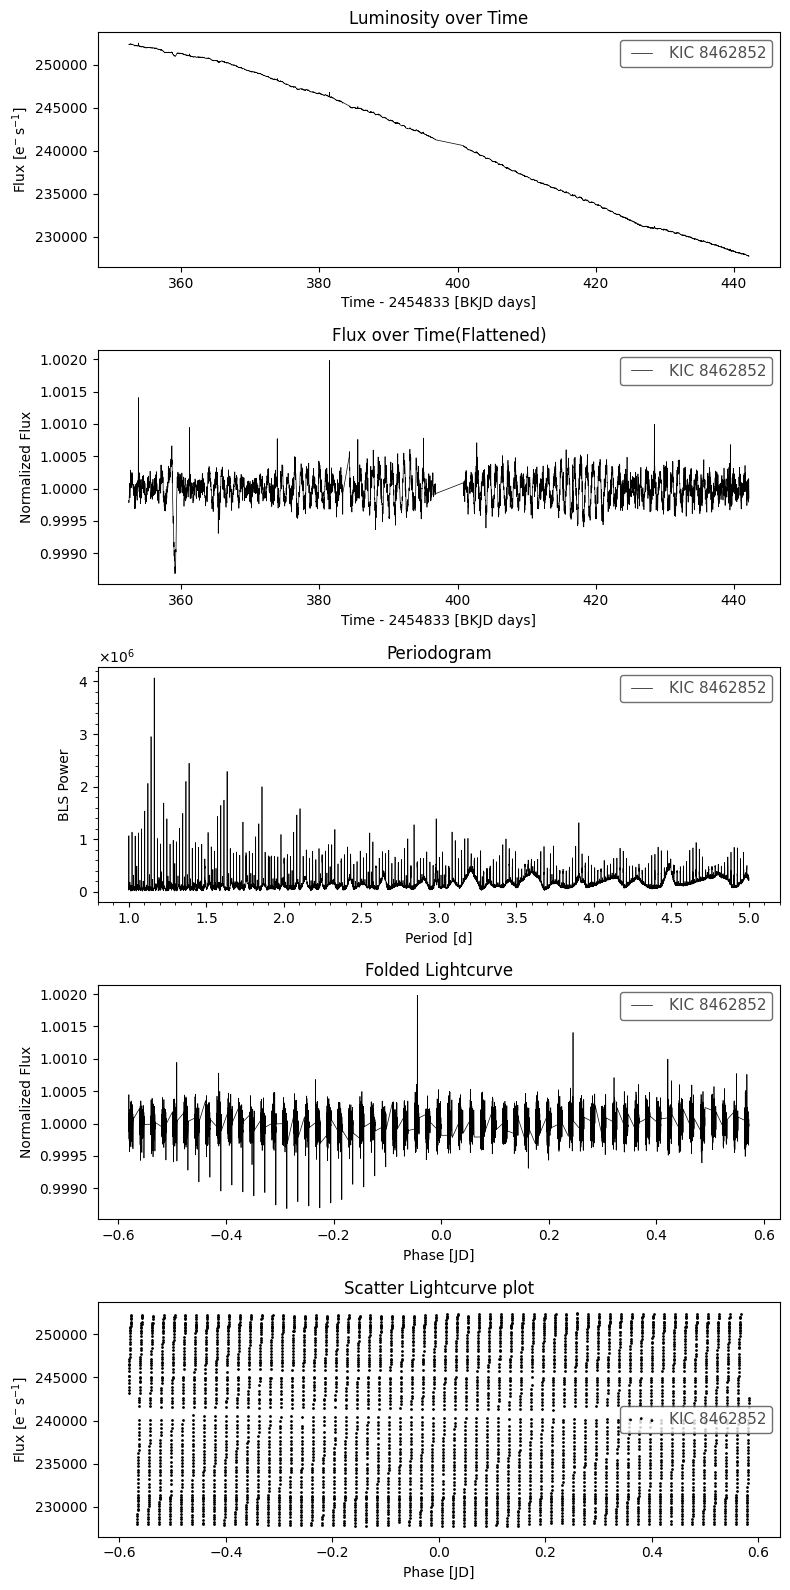

In [11]:
star = 'KIC 8462852'
analyse_star(star=star, author='kepler', quarter=4)
query = reference_finder.reference_finder(star)
query

SearchResult containing 16 data products.

 #     mission     year   author  exptime target_name distance
                                     s                 arcsec 
--- -------------- ---- --------- ------- ----------- --------
  0 TESS Sector 04 2018      SPOC     120   365369408      0.0
  1 TESS Sector 31 2020      SPOC      20   365369408      0.0
  2 TESS Sector 31 2020      SPOC     120   365369408      0.0
  3 TESS Sector 42 2021      SPOC      20   365369408      0.0
  4 TESS Sector 43 2021      SPOC      20   365369408      0.0
  5 TESS Sector 44 2021      SPOC      20   365369408      0.0
  6 TESS Sector 42 2021      SPOC     120   365369408      0.0
  7 TESS Sector 43 2021      SPOC     120   365369408      0.0
  8 TESS Sector 44 2021      SPOC     120   365369408      0.0
  9 TESS Sector 70 2023      SPOC     120   365369408      0.0
 10 TESS Sector 71 2023      SPOC     120   365369408      0.0
 11 TESS Sector 04 2018 TESS-SPOC    1800   365369408      0.0
 12 TESS Sec

bibcode,journal,title,year,volume,Pages,doi
object,object,object,int16,int32,object,object
2023AJ....165..265M,AJ,The Occurrence Rate of Terrestrial Planets Orbiting Nearby Mid-to-late M Dwarfs from TESS Sectors 1-42.,2023,165,,10.3847/1538-3881/acd175
2023AJ....165..267H,AJ,Bioverse: A Comprehensive Assessment of the Capabilities of Extremely Large Telescopes to Probe Earth-like O_2_ Levels in Nearby Transiting Habitable-zone Exoplanets.,2023,165,,10.3847/1538-3881/acd1ec
2021A&A...649A...6G,A&A,Gaia Early Data Release 3. The Gaia Catalogue of Nearby Stars.,2021,649,6-6,10.1051/0004-6361/202039498
2021AJ....161...63W,AJ,The volume-complete sample of M dwarfs with masses 0.1 {\leq} M/M_{\sun}_ {\leq} 0.3 within 15 parsecs.,2021,161,63-63,10.3847/1538-3881/abcc74
2020A&A...642A.115C,A&A,"CARMENES input catalogue of M dwarfs. V. Luminosities, colours, and spectral energy distributions.",2020,642,115-115,10.1051/0004-6361/202038295
2020ApJ...905..107M,ApJ,"Flare rates, rotation periods, and spectroscopic activity indicators of a volume-complete sample of mid- to late-M dwarfs within 15 pc.",2020,905,107-107,10.3847/1538-4357/abc686
2020ApJS..247...11R,ApJS,Radial velocity photon limits for the dwarf stars of spectral classes F-M.,2020,247,11-11,10.3847/1538-4365/ab609f
2019ApJ...874L...8K,ApJ,TESS Habitable Zone star Catalog.,2019,874,8-8,10.3847/2041-8213/ab0e8d
2019ApJ...878..134K,ApJ,Characterization of a sample of Southern M dwarfs using HARPS and X-shooter spectra.,2019,878,134-134,10.3847/1538-4357/ab1fe9


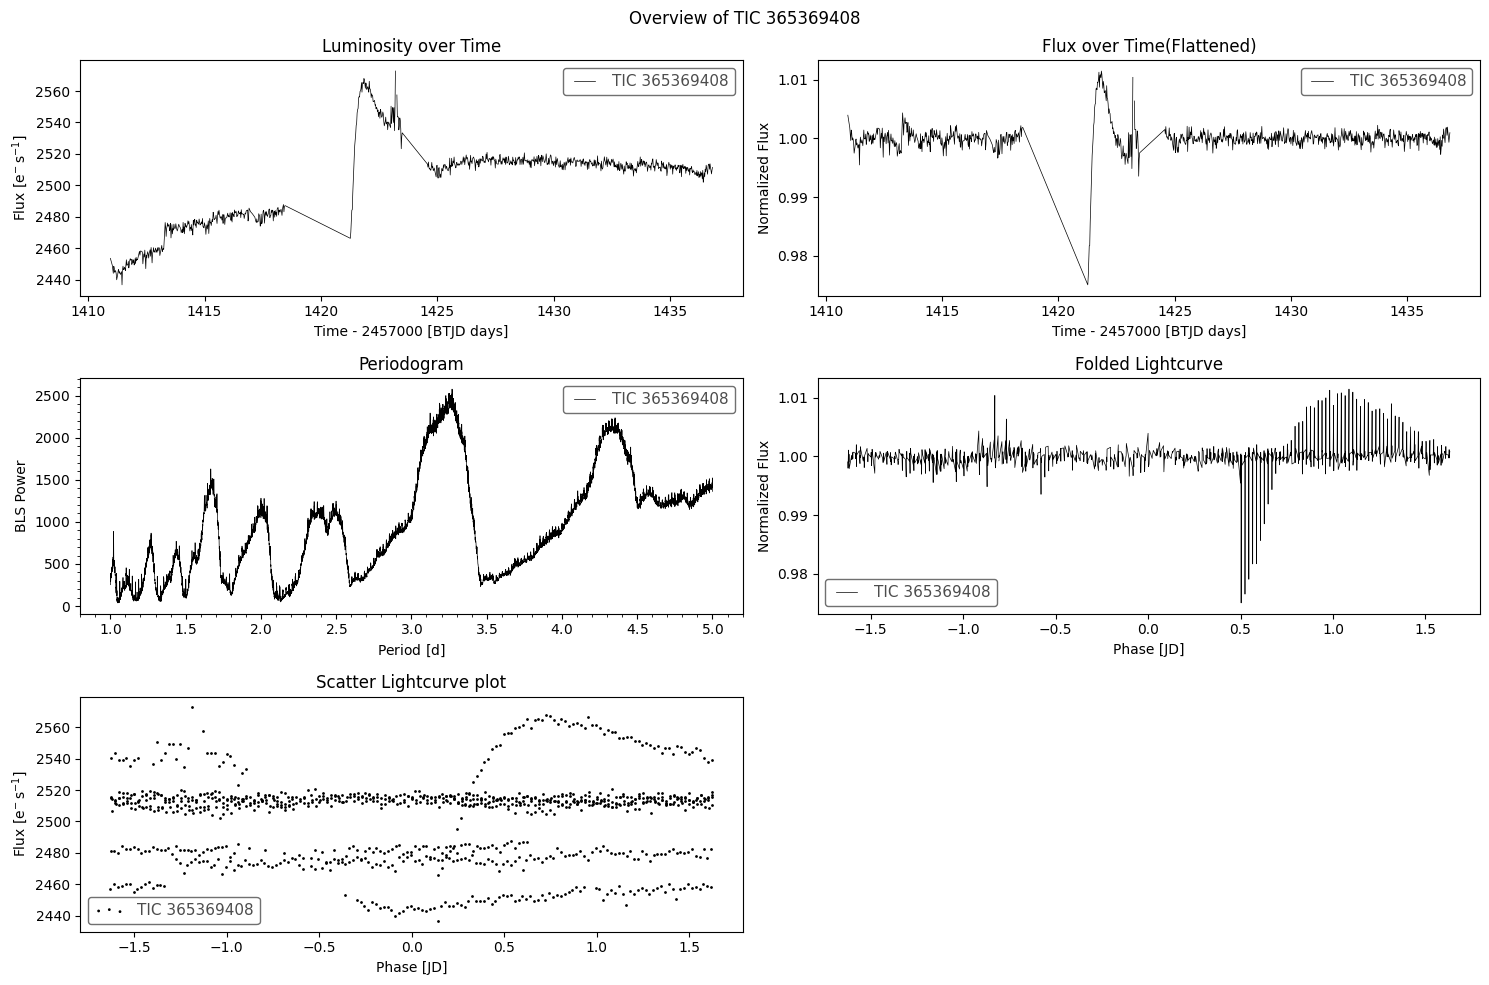

In [31]:
star = 'TIC 365369408'
analyse_star(star=star, mission='TESS', compact=True)
query = reference_finder.reference_finder(star)
query